# **3way**

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


Initial Evaluation:
Ground Truth / Predicted
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2


100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Model tested on 100 tasks. Accuracy: 96.20%
Confusion Matrix:
[[5 0 0]
 [0 5 0]
 [0 0 5]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                                                   precision    recall  f1-score   support

(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
       (Phytophthora infestans)Potato_Late_blight       1.00      1.00      1.00         5

                                         accuracy                           1.00        15
                                        macro avg       1.00      1.00      1.00        15
                                     weighted avg       1.00      1.00      1.00        15



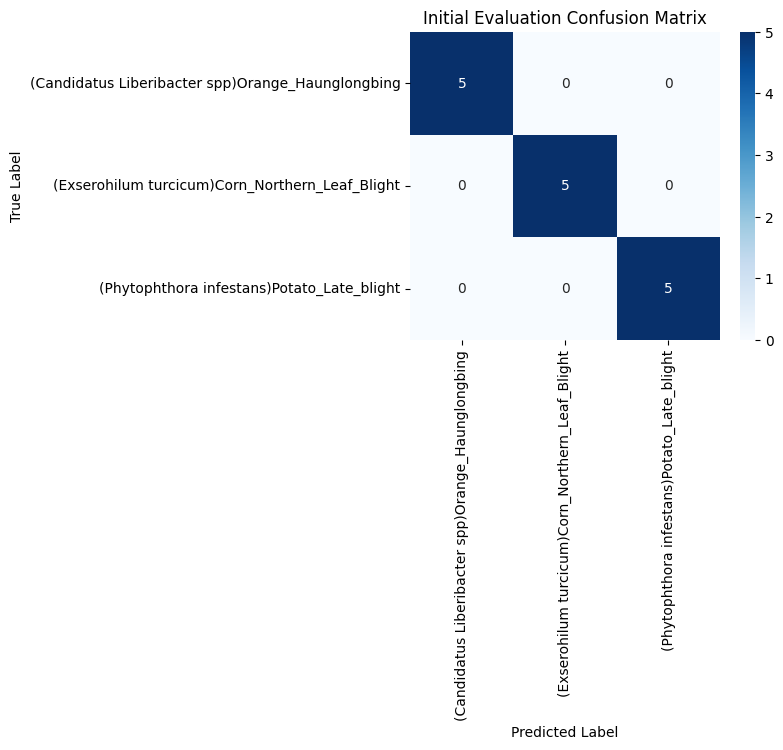

100%|██████████| 100/100 [00:16<00:00,  6.17it/s, loss=0.38]

Post-Training Evaluation:



100%|██████████| 100/100 [00:13<00:00,  7.56it/s]

Model tested on 100 tasks. Accuracy: 95.67%


In [ ]:
!pip install easyfsl scikit-learn matplotlib seaborn
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all-3way/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()


# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# Calculate metrics for the post-training evaluation
# conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
# precision = precision_score(all_true_labels, all_predicted_labels, average='macro')
# recall = recall_score(all_true_labels, all_predicted_labels, average='macro')
# f1 = f1_score(all_true_labels, all_predicted_labels, average='macro')
# class_report = classification_report(all_true_labels, all_predicted_labels, target_names=class_names)

# print(f"Confusion Matrix:\n{conf_matrix}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"Classification Report:\n{class_report}")

# Plot confusion matrix for post-training evaluation
# plt.figure(figsize=(5, 4))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.title("Post-Training Evaluation Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

Initial Evaluation:
Ground Truth / Predicted
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


Model tested on 100 tasks. Accuracy: 99.80%
Confusion Matrix:
[[5 0 0]
 [0 5 0]
 [0 0 5]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                                                   precision    recall  f1-score   support

(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
       (Phytophthora infestans)Potato_Late_blight       1.00      1.00      1.00         5

                                         accuracy                           1.00        15
                                        macro avg       1.00      1.00      1.00        15
                                     weighted avg       1.00      1.00      1.00        15



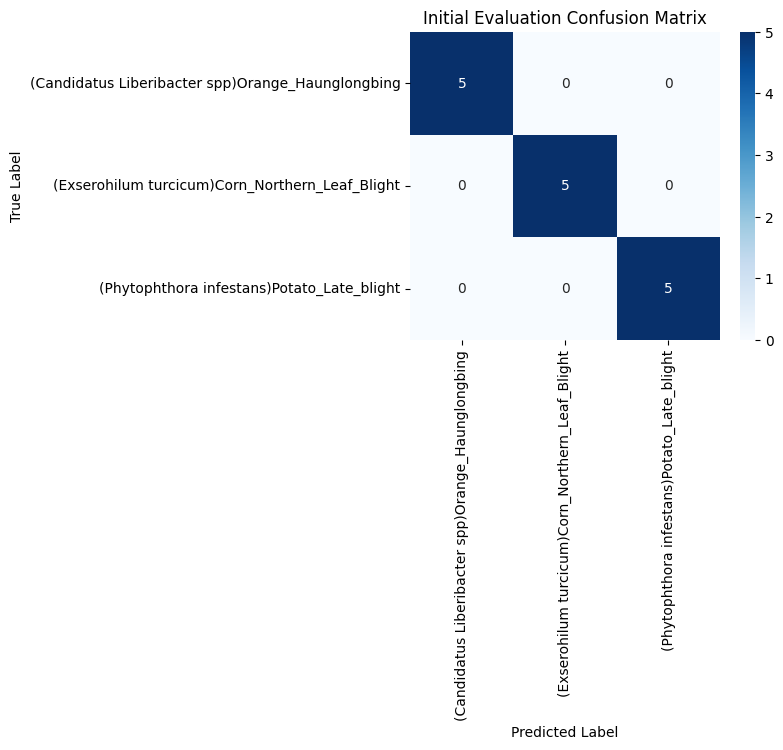

100%|██████████| 100/100 [00:21<00:00,  4.74it/s, loss=0.0989]

Post-Training Evaluation:



100%|██████████| 100/100 [00:19<00:00,  5.16it/s]

Model tested on 100 tasks. Accuracy: 100.00%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Model tested on 100 tasks. Accuracy: 100.00%
Confusion Matrix:
[[5 0 0]
 [0 5 0]
 [0 0 5]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                                                   precision    recall  f1-score   support

(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
       (Phytophthora infestans)Potato_Late_blight       1.00      1.00      1.00         5

                                         accuracy                           1.00        15
                                        macro avg       1.00      1.00      1.00        15
                                     weighted avg       1.00      1.00      1.00        15



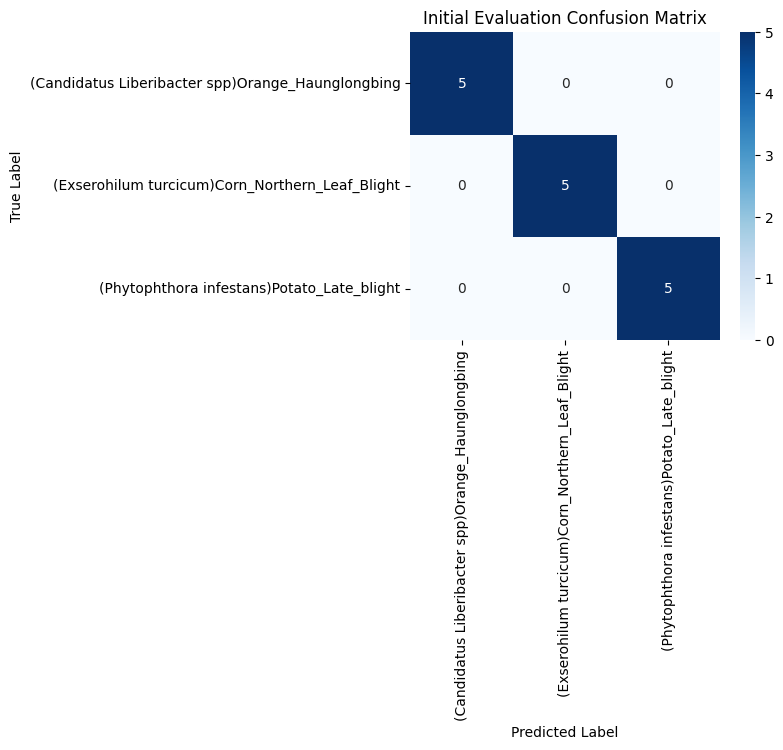

100%|██████████| 100/100 [00:32<00:00,  3.10it/s, loss=0.135]

Post-Training Evaluation:



100%|██████████| 100/100 [00:29<00:00,  3.39it/s]

Model tested on 100 tasks. Accuracy: 100.00%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 3  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# **5Way**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
0 / 0
0 / 2
0 / 0
0 / 0
0 / 0


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Model tested on 100 tasks. Accuracy: 88.08%
Confusion Matrix:
[[4 0 1 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]]
Precision: 0.9667
Recall: 0.9600
F1 Score: 0.9596
Classification Report:
                                                   precision    recall  f1-score   support

           (Botryosphaeria obtusa)Apple_Black_rot       1.00      0.80      0.89         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       0.83      1.00      0.91         5
       (Phytophthora infestans)Potato_Late_blight       1.00      1.00      1.00         5
                (Puccinia sorghi)Corn_Common_rust       1.00      1.00      1.00         5

                                         accuracy                           0.96        25
                                        macro avg       0.97      0.96      0.96        25
                                     weighted avg       0.97      0.9

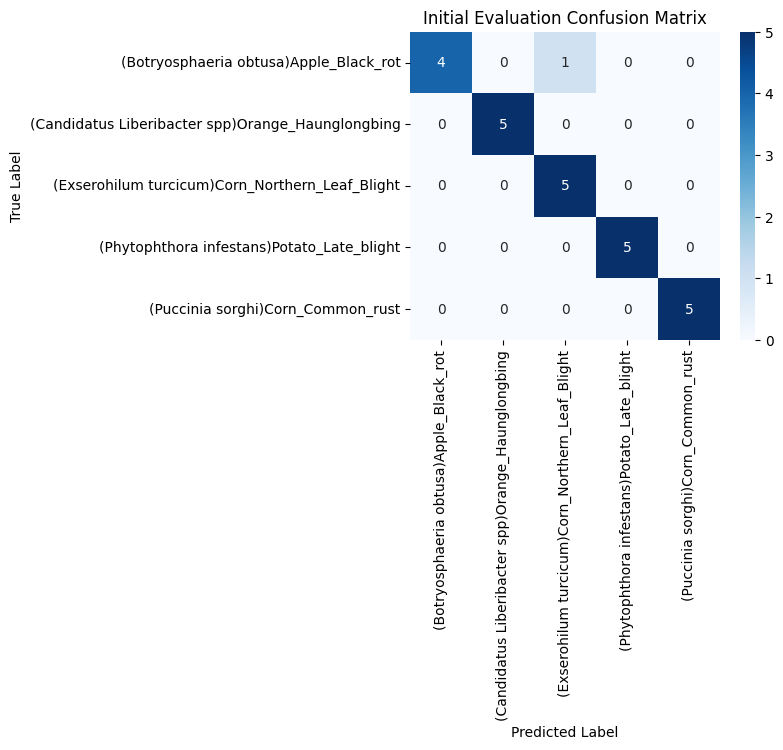

100%|██████████| 100/100 [00:21<00:00,  4.70it/s, loss=0.75]

Post-Training Evaluation:



100%|██████████| 100/100 [00:21<00:00,  4.58it/s]

Model tested on 100 tasks. Accuracy: 84.28%


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all-5way/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all-5way/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
0 / 0
0 / 0
0 / 0
0 / 4
0 / 0
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Model tested on 100 tasks. Accuracy: 95.24%
Confusion Matrix:
[[4 0 0 0 1]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]]
Precision: 0.9667
Recall: 0.9600
F1 Score: 0.9596
Classification Report:
                                                   precision    recall  f1-score   support

           (Botryosphaeria obtusa)Apple_Black_rot       1.00      0.80      0.89         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
       (Phytophthora infestans)Potato_Late_blight       1.00      1.00      1.00         5
                (Puccinia sorghi)Corn_Common_rust       0.83      1.00      0.91         5

                                         accuracy                           0.96        25
                                        macro avg       0.97      0.96      0.96        25
                                     weighted avg       0.97      0.9

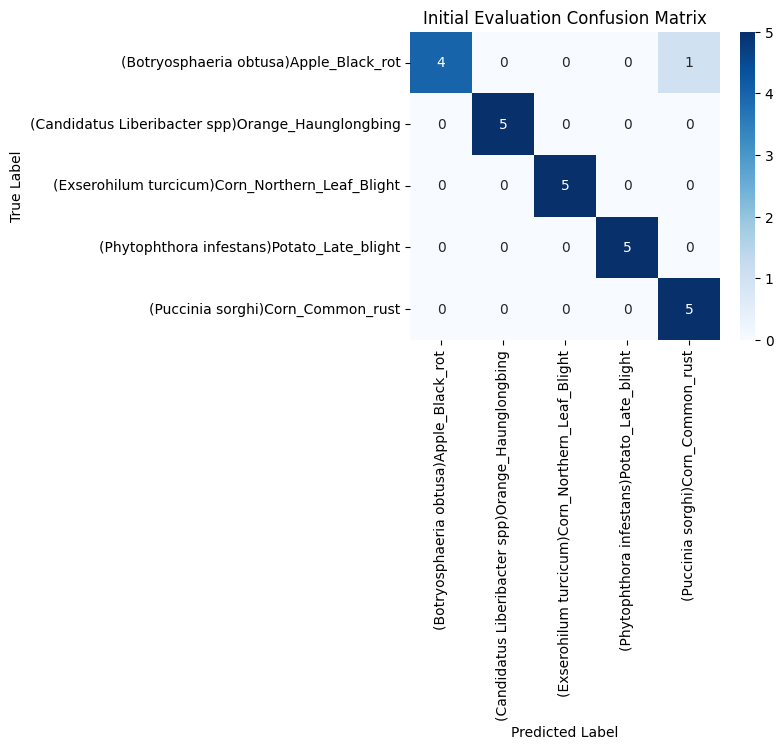

100%|██████████| 100/100 [00:35<00:00,  2.81it/s, loss=0.144]

Post-Training Evaluation:



100%|██████████| 100/100 [00:30<00:00,  3.32it/s]

Model tested on 100 tasks. Accuracy: 96.12%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Model tested on 100 tasks. Accuracy: 97.36%
Confusion Matrix:
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                                                   precision    recall  f1-score   support

           (Botryosphaeria obtusa)Apple_Black_rot       1.00      1.00      1.00         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
       (Phytophthora infestans)Potato_Late_blight       1.00      1.00      1.00         5
                (Puccinia sorghi)Corn_Common_rust       1.00      1.00      1.00         5

                                         accuracy                           1.00        25
                                        macro avg       1.00      1.00      1.00        25
                                     weighted avg       1.00      1.0

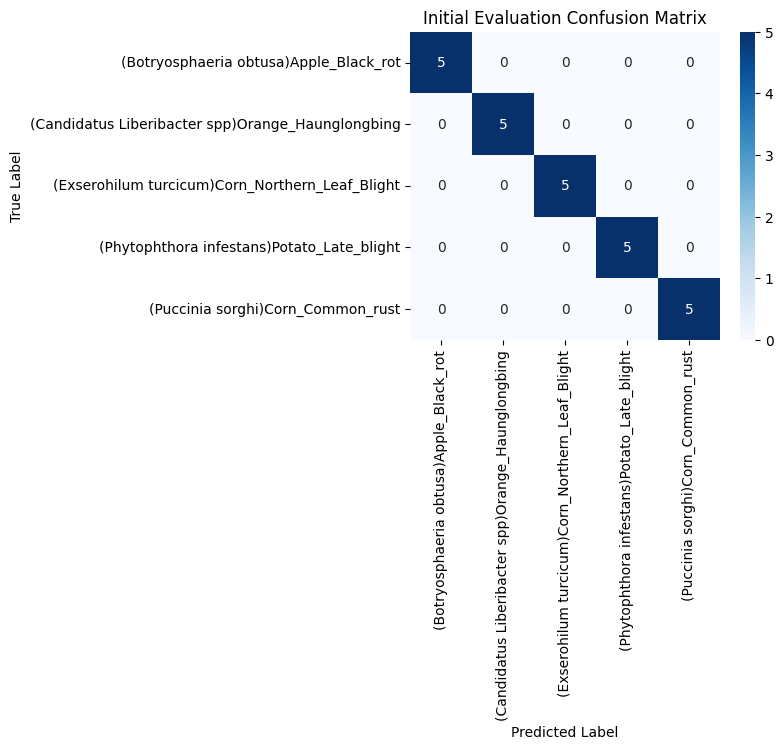

100%|██████████| 100/100 [00:49<00:00,  2.02it/s, loss=0.119]

Post-Training Evaluation:



100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Model tested on 100 tasks. Accuracy: 98.12%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 5  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# **10way**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
8 / 8
8 / 8
8 / 8
8 / 3
8 / 8
0 / 0
0 / 7
0 / 9
0 / 0
0 / 0
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
7 / 7
7 / 7
7 / 7
7 / 1
7 / 7
5 / 1
5 / 5
5 / 5
5 / 9
5 / 9
1 / 2
1 / 9
1 / 6
1 / 7
1 / 1
4 / 6
4 / 4
4 / 9
4 / 9
4 / 9
9 / 9
9 / 4
9 / 9
9 / 9
9 / 9
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


Model tested on 100 tasks. Accuracy: 66.98%
Confusion Matrix:
[[3 0 0 0 0 0 0 1 0 1]
 [0 1 1 0 0 0 1 1 0 1]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 3]
 [0 1 0 0 0 2 0 0 0 2]
 [0 0 0 0 0 0 5 0 0 0]
 [0 1 0 0 0 0 0 4 0 0]
 [0 0 0 1 0 0 0 0 4 0]
 [0 0 0 0 1 0 0 0 0 4]]
Precision: 0.7245
Recall: 0.6800
F1 Score: 0.6625
Classification Report:
                                                   precision    recall  f1-score   support

           (Alternaria solani)Potato_Early_blight       1.00      0.60      0.75         5
           (Botryosphaeria obtusa)Apple_Black_rot       0.33      0.20      0.25         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       0.83      1.00      0.91         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       0.83      1.00      0.91         5
            (Guignardia bidwellii)Grape_Black_rot       0.50      0.20      0.29         5
                (Isariopsis spp)Grape_Leaf_blight       1.00      0.40      0.57       

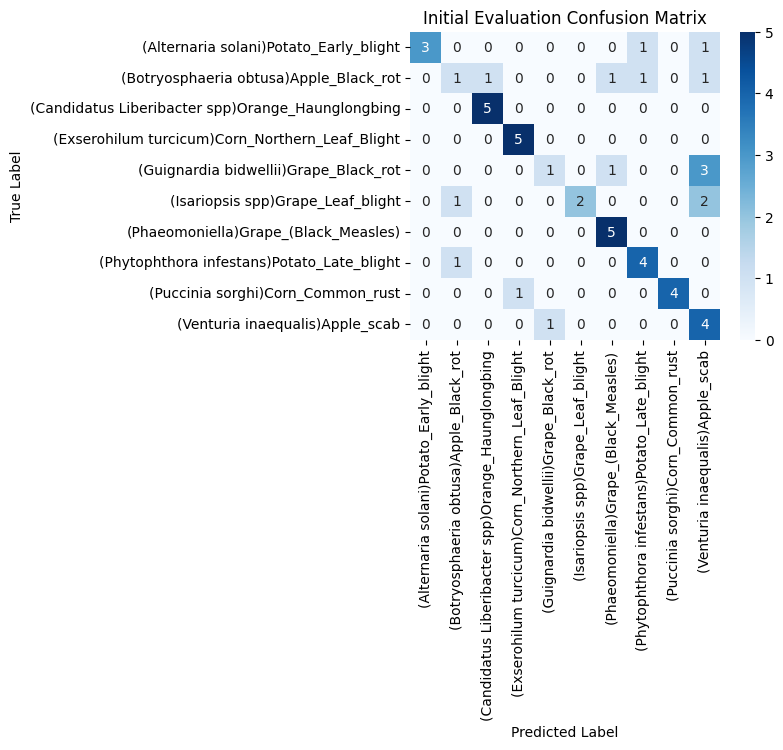

100%|██████████| 100/100 [00:43<00:00,  2.28it/s, loss=0.503]

Post-Training Evaluation:



100%|██████████| 100/100 [00:39<00:00,  2.53it/s]

Model tested on 100 tasks. Accuracy: 71.72%


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all-10way/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all-10way/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
1 / 1
1 / 1
1 / 1
1 / 0
1 / 1
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
5 / 5
5 / 5
5 / 5
5 / 5
5 / 5
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
6 / 4
6 / 0
6 / 6
6 / 4
6 / 4
9 / 9
9 / 9
9 / 9
9 / 1
9 / 9
4 / 4
4 / 4
4 / 6
4 / 4
4 / 4


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Model tested on 100 tasks. Accuracy: 86.58%
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 0 1 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [1 0 0 0 3 0 1 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 1 0 0 0 0 0 0 0 4]]
Precision: 0.8586
Recall: 0.8600
F1 Score: 0.8475
Classification Report:
                                                   precision    recall  f1-score   support

           (Alternaria solani)Potato_Early_blight       0.71      1.00      0.83         5
           (Botryosphaeria obtusa)Apple_Black_rot       0.80      0.80      0.80         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
            (Guignardia bidwellii)Grape_Black_rot       0.57      0.80      0.67         5
                (Isariopsis spp)Grape_Leaf_blight       1.00      1.00      1.00       

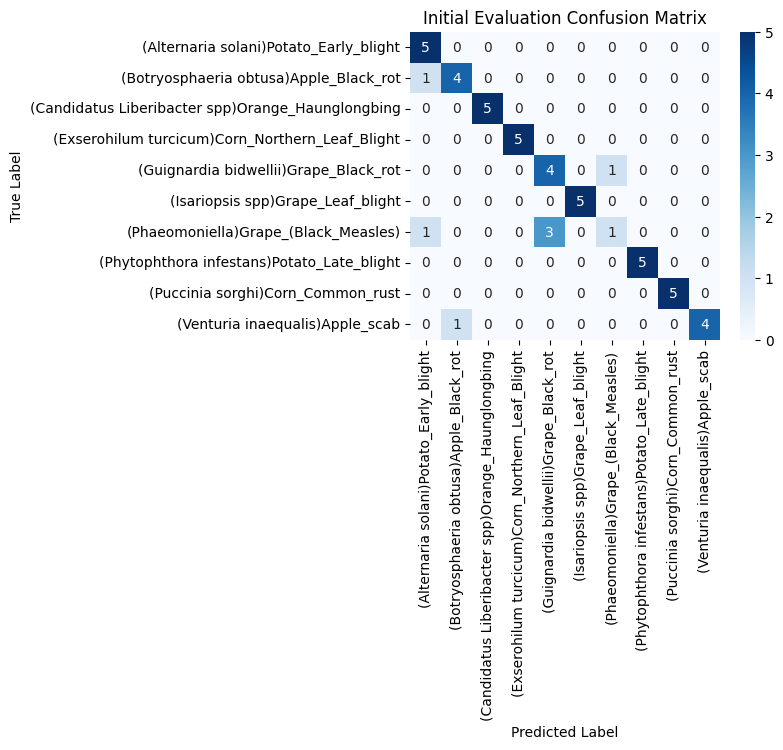

100%|██████████| 100/100 [01:12<00:00,  1.38it/s, loss=0.106]

Post-Training Evaluation:



100%|██████████| 100/100 [01:06<00:00,  1.50it/s]

Model tested on 100 tasks. Accuracy: 87.64%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
5 / 5
5 / 5
5 / 5
5 / 5
5 / 5
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
4 / 6
4 / 4
4 / 4
4 / 4
4 / 4
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
9 / 9
9 / 9
9 / 9
9 / 9
9 / 9
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2


100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


Model tested on 100 tasks. Accuracy: 90.46%
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 0 1 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]
Precision: 0.9833
Recall: 0.9800
F1 Score: 0.9798
Classification Report:
                                                   precision    recall  f1-score   support

           (Alternaria solani)Potato_Early_blight       1.00      1.00      1.00         5
           (Botryosphaeria obtusa)Apple_Black_rot       1.00      1.00      1.00         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
            (Guignardia bidwellii)Grape_Black_rot       1.00      0.80      0.89         5
                (Isariopsis spp)Grape_Leaf_blight       1.00      1.00      1.00       

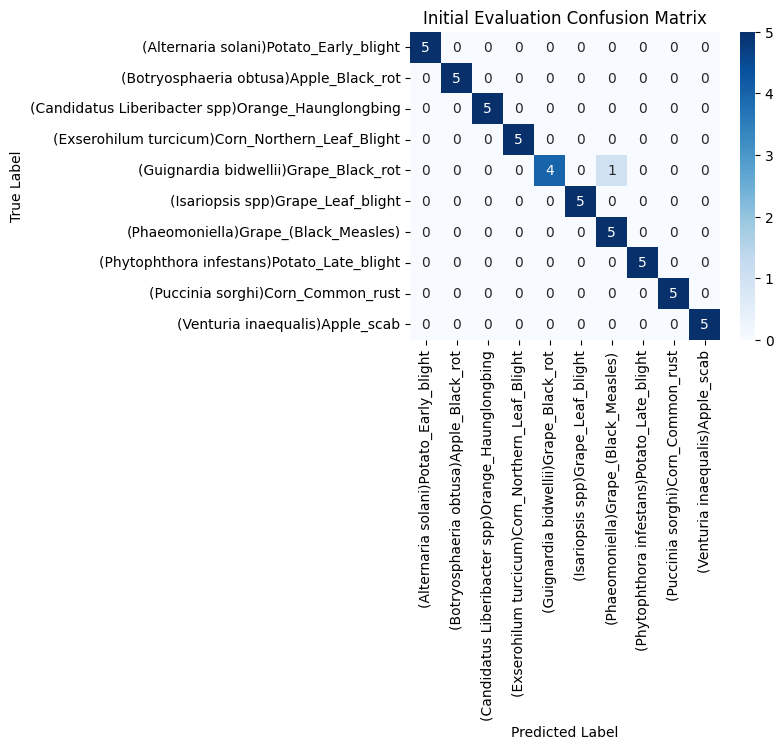

100%|██████████| 100/100 [01:46<00:00,  1.06s/it, loss=0.101]

Post-Training Evaluation:



100%|██████████| 100/100 [01:39<00:00,  1.00it/s]

Model tested on 100 tasks. Accuracy: 88.28%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# **12way**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
2 / 2
2 / 2
2 / 5
2 / 2
2 / 2
7 / 7
7 / 7
7 / 10
7 / 5
7 / 7
4 / 4
4 / 5
4 / 5
4 / 8
4 / 1
1 / 5
1 / 1
1 / 1
1 / 5
1 / 1
8 / 5
8 / 5
8 / 4
8 / 7
8 / 2
10 / 11
10 / 10
10 / 8
10 / 10
10 / 11
3 / 4
3 / 3
3 / 3
3 / 10
3 / 3
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
9 / 9
9 / 9
9 / 3
9 / 9
9 / 9
5 / 5
5 / 5
5 / 5
5 / 11
5 / 5
6 / 1
6 / 6
6 / 1
6 / 6
6 / 6
11 / 1
11 / 1
11 / 0
11 / 0
11 / 11


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Model tested on 100 tasks. Accuracy: 66.18%
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 2 0 0 0 0 0 0]
 [0 0 4 0 0 1 0 0 0 0 0 0]
 [0 0 0 3 1 0 0 0 0 0 1 0]
 [0 1 0 0 1 2 0 0 1 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 1]
 [0 2 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 1 0 3 0 0 1 0]
 [0 0 1 0 1 2 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 1 0 2 2]
 [2 2 0 0 0 0 0 0 0 0 0 1]]
Precision: 0.5672
Recall: 0.5500
F1 Score: 0.5379
Classification Report:
                                                   precision    recall  f1-score   support

(Candidatus Liberibacter spp)Orange_Haunglongbing       0.71      1.00      0.83         5
       (Corynespora cassiicola)Tomato_Target_Spot       0.38      0.60      0.46         5
    (Diplocarpon earlianum)Strawberry_Leaf_scorch       0.80      0.80      0.80         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       0.75      0.60      0.67         5
            (Guignardia bidwellii)Grape_Black_rot       0.33      0.20      0.25    

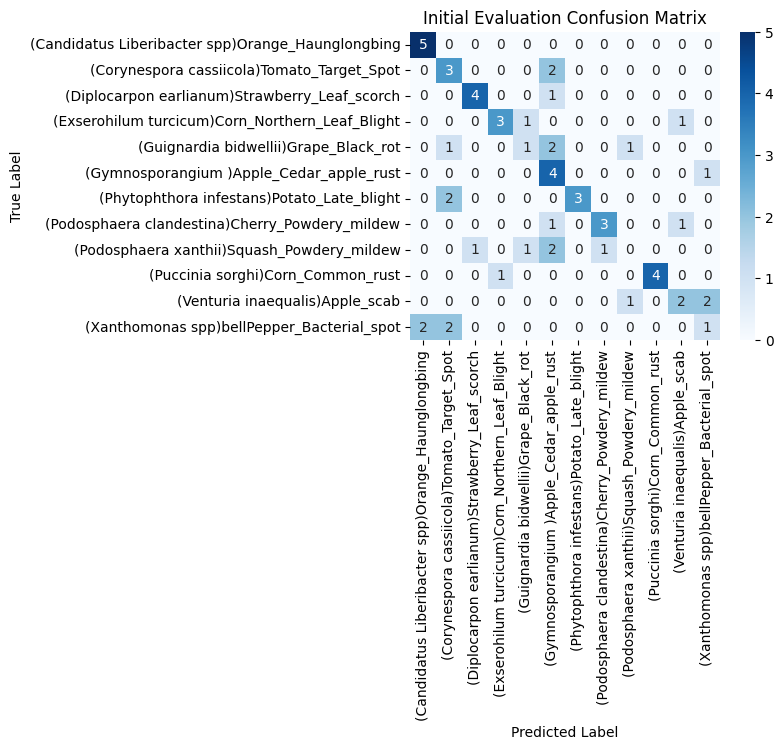

100%|██████████| 100/100 [00:50<00:00,  1.97it/s, loss=0.334]

Post-Training Evaluation:



100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Model tested on 100 tasks. Accuracy: 71.38%


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all-12way/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all-12way/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 12  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
9 / 9
9 / 9
9 / 3
9 / 9
9 / 9
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
5 / 10
5 / 5
5 / 10
5 / 10
5 / 5
11 / 11
11 / 11
11 / 11
11 / 6
11 / 11
10 / 10
10 / 10
10 / 10
10 / 10
10 / 10
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Model tested on 100 tasks. Accuracy: 89.17%
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 3 0]
 [0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 1 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 1 0 0 0 0 4]]
Precision: 0.9410
Recall: 0.9167
F1 Score: 0.9114
Classification Report:
                                                   precision    recall  f1-score   support

(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
       (Corynespora cassiicola)Tomato_Target_Spot       1.00      1.00      1.00         5
    (Diplocarpon earlianum)Strawberry_Leaf_scorch       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       0.83      1.00      0.91         5
            (Guignardia bidwellii)Grape_Black_rot       1.00      1.00      1.00    

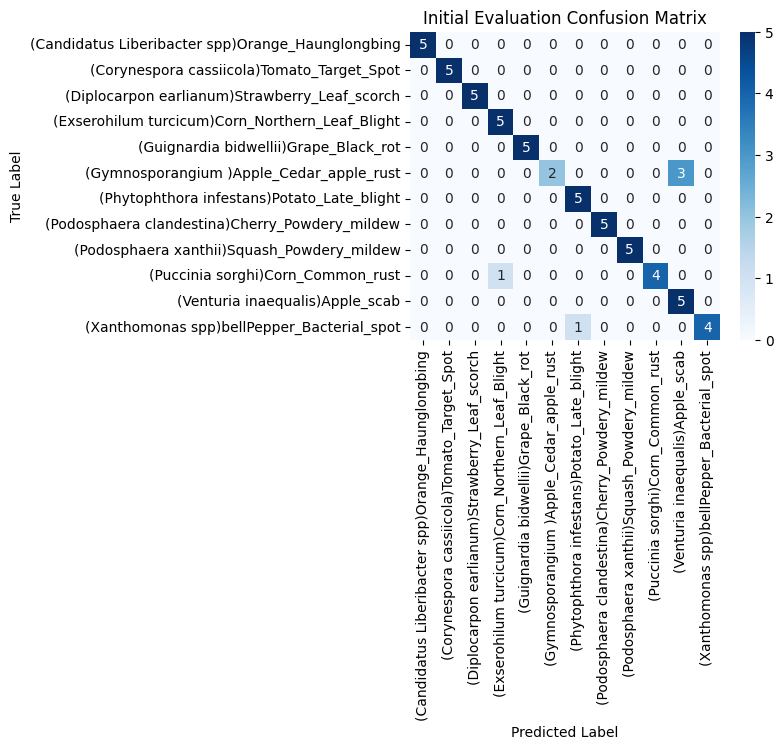

100%|██████████| 100/100 [01:22<00:00,  1.22it/s, loss=0.106]

Post-Training Evaluation:



100%|██████████| 100/100 [01:16<00:00,  1.30it/s]

Model tested on 100 tasks. Accuracy: 89.57%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 12  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
10 / 1
10 / 5
10 / 10
10 / 10
10 / 4
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
5 / 5
5 / 5
5 / 5
5 / 5
5 / 5
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
9 / 9
9 / 9
9 / 9
9 / 9
9 / 9
8 / 3
8 / 8
8 / 8
8 / 8
8 / 8
11 / 11
11 / 0
11 / 11
11 / 11
11 / 11
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


Model tested on 100 tasks. Accuracy: 92.15%
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 1 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0]
 [0 1 0 0 1 1 0 0 0 0 2 0]
 [1 0 0 0 0 0 0 0 0 0 0 4]]
Precision: 0.9306
Recall: 0.9167
F1 Score: 0.9079
Classification Report:
                                                   precision    recall  f1-score   support

(Candidatus Liberibacter spp)Orange_Haunglongbing       0.83      1.00      0.91         5
       (Corynespora cassiicola)Tomato_Target_Spot       0.83      1.00      0.91         5
    (Diplocarpon earlianum)Strawberry_Leaf_scorch       1.00      1.00      1.00         5
  (Exserohilum turcicum)Corn_Northern_Leaf_Blight       0.83      1.00      0.91         5
            (Guignardia bidwellii)Grape_Black_rot       0.83      1.00      0.91    

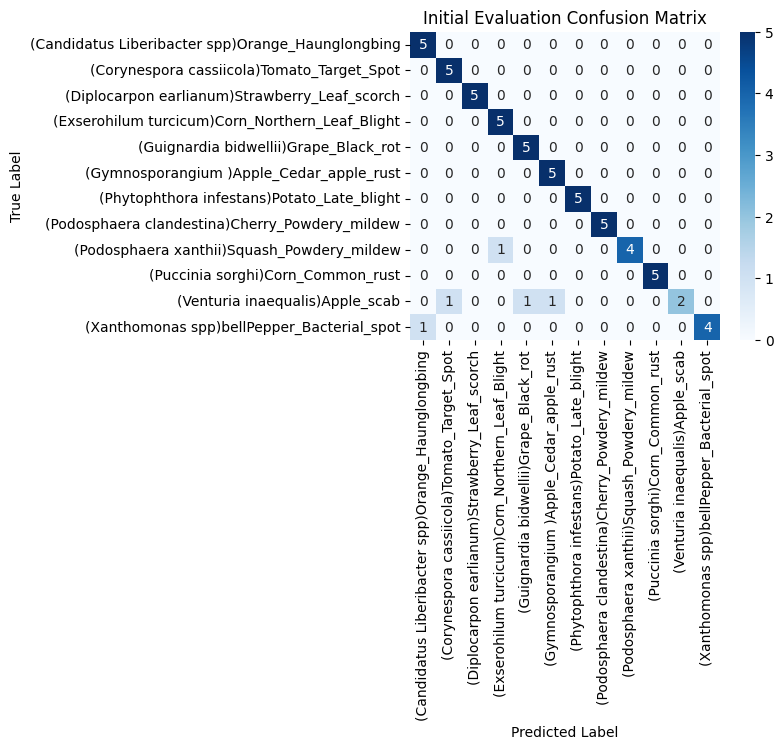

100%|██████████| 100/100 [02:00<00:00,  1.20s/it, loss=0.0923]

Post-Training Evaluation:



100%|██████████| 100/100 [01:54<00:00,  1.15s/it]

Model tested on 100 tasks. Accuracy: 91.82%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 12  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# **15way**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
13 / 10
13 / 13
13 / 13
13 / 13
13 / 13
6 / 7
6 / 6
6 / 13
6 / 6
6 / 8
10 / 7
10 / 10
10 / 10
10 / 10
10 / 10
0 / 9
0 / 0
0 / 9
0 / 0
0 / 9
11 / 7
11 / 7
11 / 4
11 / 11
11 / 7
12 / 0
12 / 0
12 / 12
12 / 0
12 / 12
8 / 8
8 / 5
8 / 5
8 / 5
8 / 5
3 / 3
3 / 7
3 / 3
3 / 7
3 / 0
9 / 9
9 / 9
9 / 9
9 / 9
9 / 9
7 / 7
7 / 7
7 / 7
7 / 7
7 / 0
2 / 9
2 / 2
2 / 5
2 / 2
2 / 8
5 / 5
5 / 5
5 / 8
5 / 13
5 / 5
14 / 14
14 / 14
14 / 13
14 / 9
14 / 14


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Model tested on 100 tasks. Accuracy: 60.55%
Confusion Matrix:
[[2 0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 1 0 0 1 1 0 0 0 0 0]
 [1 0 0 2 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 2 1 1 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 4 0 0 0 0]
 [0 0 0 0 1 0 0 3 0 0 0 1 0 0 0]
 [3 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 3]]
Precision: 0.7319
Recall: 0.6000
F1 Score: 0.5952
Classification Report:
                                                   precision    recall  f1-score   support

           (Alternaria solani)Potato_Early_blight       0.29      0.40      0.33         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
       (Corynespora cassiicola)Tomato_Target_Spot       1.00      0.40      0.57         5
    

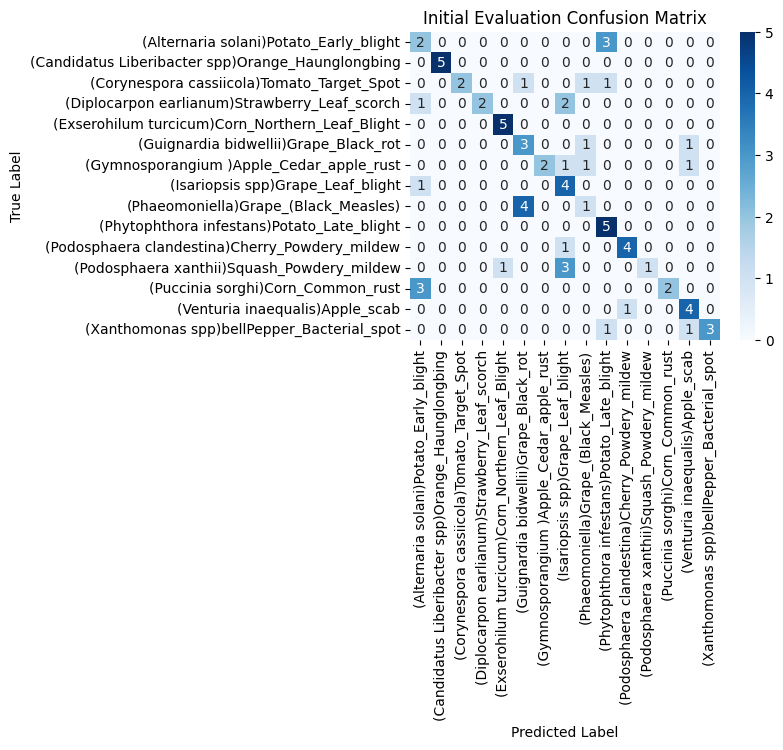

100%|██████████| 100/100 [01:04<00:00,  1.56it/s, loss=0.39]

Post-Training Evaluation:



100%|██████████| 100/100 [01:01<00:00,  1.64it/s]

Model tested on 100 tasks. Accuracy: 75.09%


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 15  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
12 / 12
12 / 12
12 / 12
12 / 12
12 / 12
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
13 / 13
13 / 13
13 / 13
13 / 13
13 / 13
0 / 0
0 / 0
0 / 0
0 / 9
0 / 0
9 / 9
9 / 9
9 / 9
9 / 9
9 / 9
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
11 / 11
11 / 11
11 / 11
11 / 11
11 / 11
5 / 5
5 / 5
5 / 5
5 / 5
5 / 5
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
14 / 14
14 / 1
14 / 1
14 / 14
14 / 14
10 / 10
10 / 10
10 / 10
10 / 10
10 / 10


100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Model tested on 100 tasks. Accuracy: 89.20%
Confusion Matrix:
[[4 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 3]]
Precision: 0.9698
Recall: 0.9600
F1 Score: 0.9588
Classification Report:
                                                   precision    recall  f1-score   support

           (Alternaria solani)Potato_Early_blight       1.00      0.80      0.89         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       0.71      1.00      0.83         5
       (Corynespora cassiicola)Tomato_Target_Spot       1.00      1.00      1.00         5
    

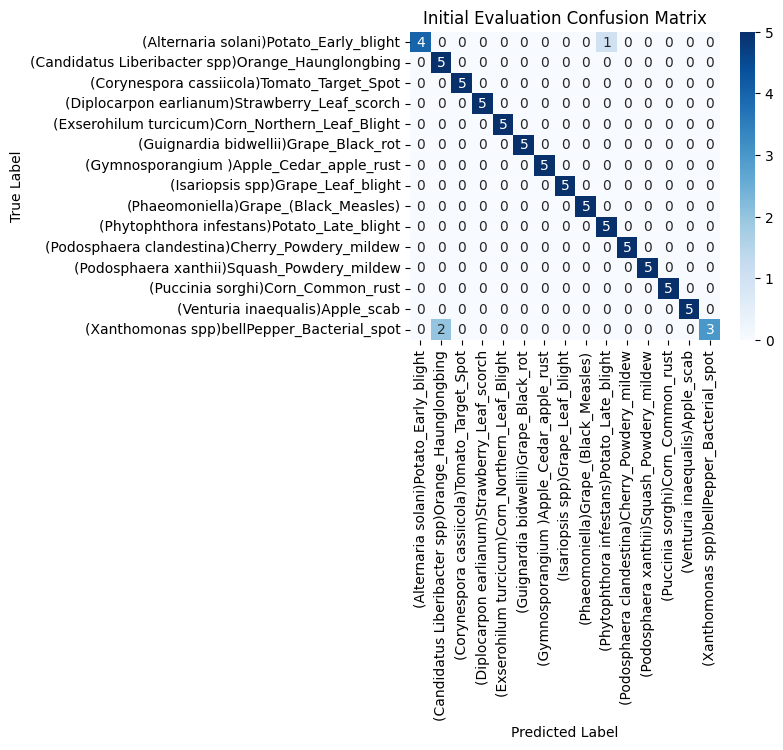

100%|██████████| 100/100 [01:41<00:00,  1.01s/it, loss=0.0982]

Post-Training Evaluation:



100%|██████████| 100/100 [01:35<00:00,  1.04it/s]

Model tested on 100 tasks. Accuracy: 86.85%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 15  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
8 / 8
8 / 5
8 / 8
8 / 0
8 / 8
11 / 11
11 / 11
11 / 11
11 / 11
11 / 11
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
13 / 13
13 / 13
13 / 13
13 / 13
13 / 13
12 / 12
12 / 12
12 / 12
12 / 12
12 / 12
0 / 0
0 / 0
0 / 9
0 / 0
0 / 0
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
14 / 8
14 / 14
14 / 14
14 / 14
14 / 14
2 / 9
2 / 2
2 / 2
2 / 2
2 / 2
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
10 / 10
10 / 10
10 / 10
10 / 10
10 / 10
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
9 / 9
9 / 9
9 / 9
9 / 9
9 / 9
5 / 5
5 / 5
5 / 5
5 / 5
5 / 13


100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


Model tested on 100 tasks. Accuracy: 88.53%
Confusion Matrix:
[[4 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 4]]
Precision: 0.9265
Recall: 0.9200
F1 Score: 0.9191
Classification Report:
                                                   precision    recall  f1-score   support

           (Alternaria solani)Potato_Early_blight       0.80      0.80      0.80         5
(Candidatus Liberibacter spp)Orange_Haunglongbing       1.00      1.00      1.00         5
       (Corynespora cassiicola)Tomato_Target_Spot       1.00      0.80      0.89         5
    

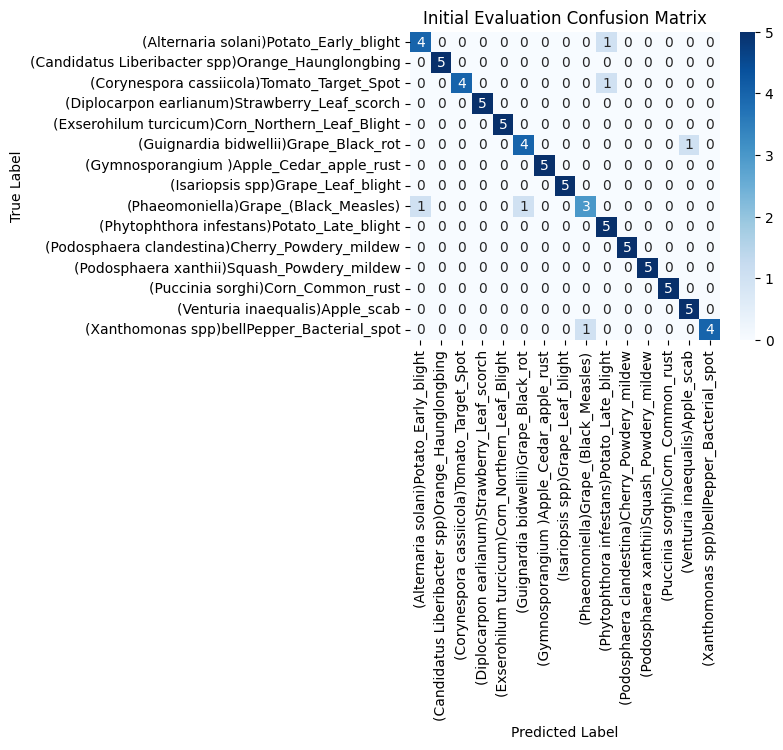

100%|██████████| 100/100 [02:34<00:00,  1.54s/it, loss=0.105]

Post-Training Evaluation:



100%|██████████| 100/100 [02:23<00:00,  1.43s/it]

Model tested on 100 tasks. Accuracy: 89.79%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 15  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

# **10wayold**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initial Evaluation:
Ground Truth / Predicted
2 / 3
2 / 2
2 / 2
2 / 2
2 / 3
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
5 / 4
5 / 4
5 / 4
5 / 4
5 / 0
4 / 4
4 / 4
4 / 5
4 / 4
4 / 4
1 / 5
1 / 5
1 / 8
1 / 9
1 / 9
8 / 8
8 / 8
8 / 8
8 / 9
8 / 8
9 / 9
9 / 9
9 / 9
9 / 8
9 / 9
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
0 / 8
0 / 7
0 / 9
0 / 8
0 / 0
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Model tested on 100 tasks. Accuracy: 68.04%
Confusion Matrix:
[[1 0 0 0 0 0 0 1 2 1]
 [0 0 0 0 0 2 0 0 1 2]
 [0 0 3 2 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 1 0 0 0 0]
 [1 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 4 1]
 [0 0 0 0 0 0 0 0 1 4]]
Precision: 0.5548
Recall: 0.6200
F1 Score: 0.5624
Classification Report:
                           precision    recall  f1-score   support

          Apple_Black_rot       0.50      0.20      0.29         5
               Apple_scab       0.00      0.00      0.00         5
         Corn_Common_rust       1.00      0.60      0.75         5
Corn_Northern_Leaf_Blight       0.71      1.00      0.83         5
    Grape_(Black_Measles)       0.50      0.80      0.62         5
          Grape_Black_rot       0.00      0.00      0.00         5
        Grape_Leaf_blight       1.00      1.00      1.00         5
     Orange_Haunglongbing       0.83      1.00      0.91         5
      Potato_Early_blight     

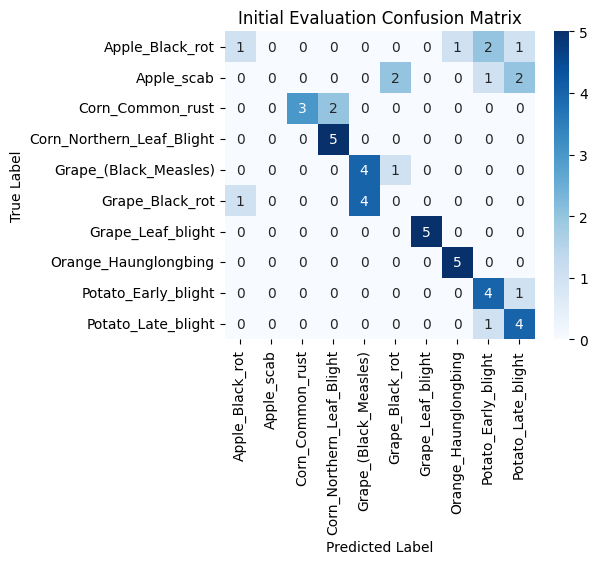

100%|██████████| 100/100 [00:42<00:00,  2.34it/s, loss=0.498]

Post-Training Evaluation:



100%|██████████| 100/100 [00:39<00:00,  2.51it/s]

Model tested on 100 tasks. Accuracy: 69.62%


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the image size
image_size = 224

# Define the paths to your dataset
train_data_path = '/content/drive/MyDrive/plantvillage-all-10way-old/plantvillage/dataset/train'
test_data_path = '/content/drive/MyDrive/plantvillage-all-10way-old/plantvillage/dataset/test'

# Define the dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

    def get_labels(self):
        return [label for _, label in self.dataset]

    def get_class_names(self):
        return self.dataset.classes

# Define the data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_set = PlantVillageDataset(root=train_data_path, transform=data_transforms['train'])
test_set = PlantVillageDataset(root=test_data_path, transform=data_transforms['test'])

# Get class names
class_names = test_set.get_class_names()

# Define the Prototypical Networks model
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

# Load the pretrained ResNet50 model
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

# print(convolutional_network)

# Create the Prototypical Networks model
model = PrototypicalNetworks(convolutional_network).cuda()

# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 1  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
9 / 8
9 / 9
9 / 8
9 / 9
9 / 9
8 / 8
8 / 8
8 / 8
8 / 8
8 / 8
5 / 4
5 / 5
5 / 5
5 / 5
5 / 5
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
4 / 4
4 / 5
4 / 5
4 / 4
4 / 4
0 / 0
0 / 1
0 / 0
0 / 0
0 / 0
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
1 / 1
1 / 1
1 / 1
1 / 1
1 / 9
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


Model tested on 100 tasks. Accuracy: 87.04%
Confusion Matrix:
[[4 1 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 1]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 3 2 0 0 0 0]
 [0 0 0 0 1 4 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 2 3]]
Precision: 0.8681
Recall: 0.8600
F1 Score: 0.8583
Classification Report:
                           precision    recall  f1-score   support

          Apple_Black_rot       1.00      0.80      0.89         5
               Apple_scab       0.80      0.80      0.80         5
         Corn_Common_rust       1.00      1.00      1.00         5
Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
    Grape_(Black_Measles)       0.75      0.60      0.67         5
          Grape_Black_rot       0.67      0.80      0.73         5
        Grape_Leaf_blight       1.00      1.00      1.00         5
     Orange_Haunglongbing       1.00      1.00      1.00         5
      Potato_Early_blight     

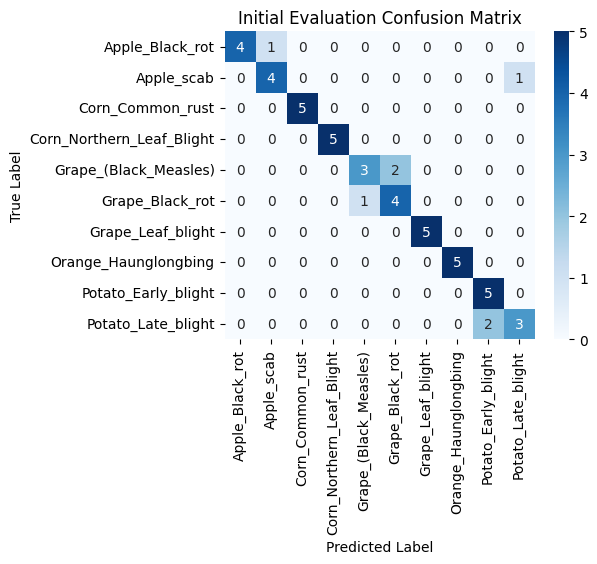

100%|██████████| 100/100 [01:10<00:00,  1.43it/s, loss=0.115]

Post-Training Evaluation:



100%|██████████| 100/100 [01:03<00:00,  1.57it/s]

Model tested on 100 tasks. Accuracy: 84.64%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)

Initial Evaluation:
Ground Truth / Predicted
8 / 8
8 / 0
8 / 8
8 / 8
8 / 8
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
9 / 9
9 / 9
9 / 9
9 / 9
9 / 0
1 / 9
1 / 1
1 / 0
1 / 1
1 / 0
0 / 0
0 / 0
0 / 0
0 / 0
0 / 0
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
3 / 3
3 / 3
3 / 3
3 / 3
3 / 3
5 / 5
5 / 5
5 / 5
5 / 5
5 / 1
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
4 / 4
4 / 5
4 / 8
4 / 4
4 / 4


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


Model tested on 100 tasks. Accuracy: 87.24%
Confusion Matrix:
[[5 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 1]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 3 1 0 0 1 0]
 [0 1 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [1 0 0 0 0 0 0 0 4 0]
 [1 0 0 0 0 0 0 0 0 4]]
Precision: 0.8622
Recall: 0.8400
F1 Score: 0.8364
Classification Report:
                           precision    recall  f1-score   support

          Apple_Black_rot       0.56      1.00      0.71         5
               Apple_scab       0.67      0.40      0.50         5
         Corn_Common_rust       1.00      1.00      1.00         5
Corn_Northern_Leaf_Blight       1.00      1.00      1.00         5
    Grape_(Black_Measles)       1.00      0.60      0.75         5
          Grape_Black_rot       0.80      0.80      0.80         5
        Grape_Leaf_blight       1.00      1.00      1.00         5
     Orange_Haunglongbing       1.00      1.00      1.00         5
      Potato_Early_blight     

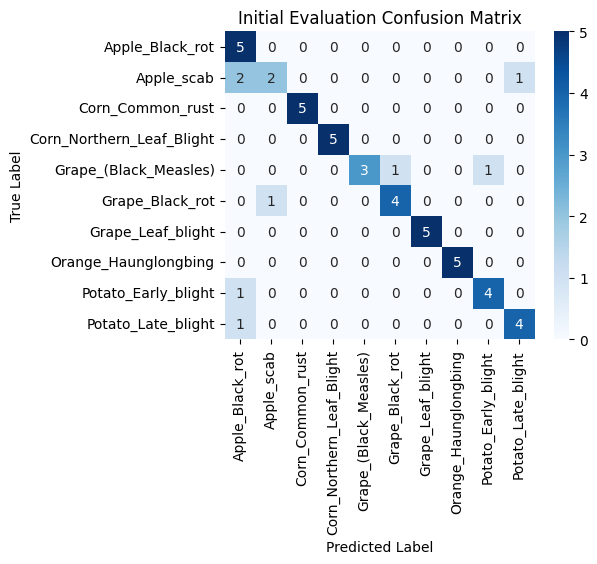

100%|██████████| 100/100 [01:47<00:00,  1.07s/it, loss=0.0835]

Post-Training Evaluation:



100%|██████████| 100/100 [01:36<00:00,  1.03it/s]

Model tested on 100 tasks. Accuracy: 87.68%


In [ ]:
# Define parameters for few-shot learning
N_WAY = 10  # Number of classes in a task
N_SHOT = 10  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# Create Task Samplers
train_sampler = TaskSampler(train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
test_sampler = TaskSampler(test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)

# Create DataLoaders
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=2, pin_memory=True, collate_fn=train_sampler.episodic_collate_fn)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=2, pin_memory=True, collate_fn=test_sampler.episodic_collate_fn)

# Example of loading and visualizing data
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))
# plot_images(example_support_images, "support images", images_per_row=N_SHOT)
# plot_images(example_query_images, "query images", images_per_row=N_QUERY)

# Evaluate the model
model.eval()
example_scores = model(example_support_images.cuda(), example_support_labels.cuda(), example_query_images.cuda()).detach()
_, example_predicted_labels = torch.max(example_scores.data, 1)
print("Initial Evaluation:")
print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(f"{example_query_labels[i].item()} / {example_predicted_labels[i].item()}")

# Define evaluation functions
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (torch.max(model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data, 1)[1] == query_labels.cuda()).sum().item(), len(query_labels)

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

# Evaluate the model
evaluate(test_loader)

# Calculate metrics for the initial evaluation
conf_matrix = confusion_matrix(example_query_labels.cpu(), example_predicted_labels.cpu())
precision = precision_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
recall = recall_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
f1 = f1_score(example_query_labels.cpu(), example_predicted_labels.cpu(), average='macro')
class_report = classification_report(example_query_labels.cpu(), example_predicted_labels.cpu(), target_names=class_names)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classification Report:\n{class_report}")


# Plot confusion matrix for initial evaluation
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Initial Evaluation Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


N_TRAINING_EPISODES = 100
N_EVALUATION_TASKS = 100

# Samplers
#train_set.get_labels = lambda: [label for _, label in train_set.imgs]
#test_set.get_labels = lambda: [label for _, label in test_set.imgs]

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)

# DataLoaders
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,  # Adjust based on your environment
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define the fit function
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
log_update_frequency = 10
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

# Evaluate the model after training
print("Post-Training Evaluation:")
evaluate(test_loader)

# Define a function to gather all predictions and true labels for the evaluation
def gather_predictions_and_labels(data_loader: DataLoader):
    all_true_labels = []
    all_predicted_labels = []

    model.eval()
    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels, class_ids in data_loader:
            scores = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach()
            _, predicted_labels = torch.max(scores.data, 1)
            all_true_labels.extend(query_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# Gather predictions and true labels for the post-training evaluation
all_true_labels, all_predicted_labels = gather_predictions_and_labels(test_loader)